In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Veriyi yükleme ve ön işleme
df = pd.read_excel("rainfall-and-daily-consumption-data-on-istanbul-dams.xlsx")

df = df[['Tarih', 'İstanbul günlük tüketim(m³/gün)']]
df = df.set_index("Tarih")
df.index = pd.to_datetime(df.index)
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'] // 100
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'].astype(float)
df = np.log(df)

# Eğitim ve test veri setlerini ayırma
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

# Özellikleri oluşturma
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'İstanbul günlük tüketim(m³/gün)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Veriyi normalize etme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# LightGBM modelini oluşturma ve eğitme
lgbm_reg = LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=100, random_state=42)
lgbm_reg.fit(X_train, y_train)

# Test verileri üzerinde tahmin yapma
y_pred = lgbm_reg.predict(X_test)

# Tahminleri orijinal ölçeğe döndürme
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 3771, number of used features: 5
[LightGBM] [Info] Start training from score 0.568110
Mean Squared Error (MSE): 0.0035
Root Mean Squared Error (RMSE): 0.0590
Mean Absolute Error (MAE): 0.051124589313006286
Mean Absolute Percentage Error (MAPE): 0.4947189742362716


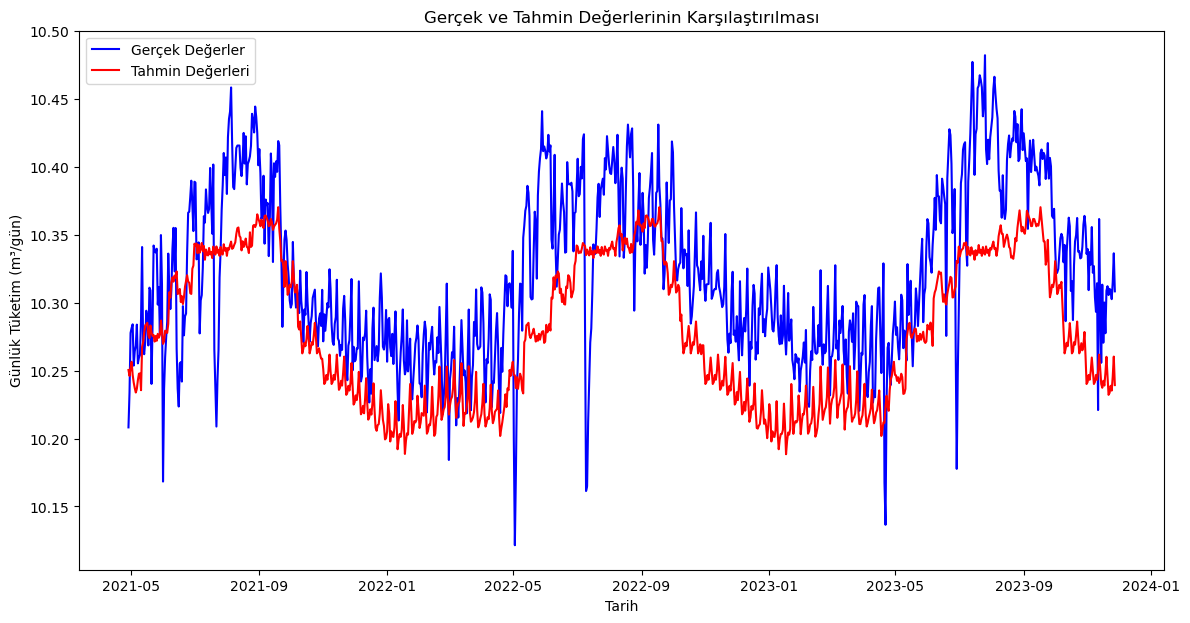

In [5]:
# Gerçek ve tahmin değerleri birleştirme
results = pd.DataFrame({'Tarih': test.index, 'Gerçek': y_test_orig.flatten(), 'Tahmin': y_pred_orig.flatten()})
results = results.set_index('Tarih')

# Görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.title('Gerçek ve Tahmin Değerlerinin Karşılaştırılması')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()


In [7]:


from datetime import datetime, timedelta

# Gelecek 10 günün tarih aralığını belirleme
start_date = df.index[-1] + timedelta(days=1)
end_date = start_date + timedelta(days=9)
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Gelecek 10 gün için özellikler oluşturma
forecast_features = create_features(pd.DataFrame(index=forecast_dates))

# Özellikleri normalize etme
forecast_features_normalized = scaler_X.transform(forecast_features)

# Gelecek 10 günün su tüketimini tahmin etme
forecast_scaled = lgbm_reg.predict(forecast_features_normalized)

# Tahminleri orijinal ölçeklere dönüştürme
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Tahminleri ve tarihleri birleştirme
forecast_results = pd.DataFrame({'Tarih': forecast_dates, 'Tahmin Edilen Su Tüketimi (m³/gün)': forecast})
forecast_results = forecast_results.set_index('Tarih')

print(forecast_results)

            Tahmin Edilen Su Tüketimi (m³/gün)
Tarih                                         
2023-11-28                           10.224950
2023-11-29                           10.226530
2023-11-30                           10.234184
2023-12-01                           10.230642
2023-12-02                           10.239242
2023-12-03                           10.253898
2023-12-04                           10.232267
2023-12-05                           10.217852
2023-12-06                           10.219361
2023-12-07                           10.227016


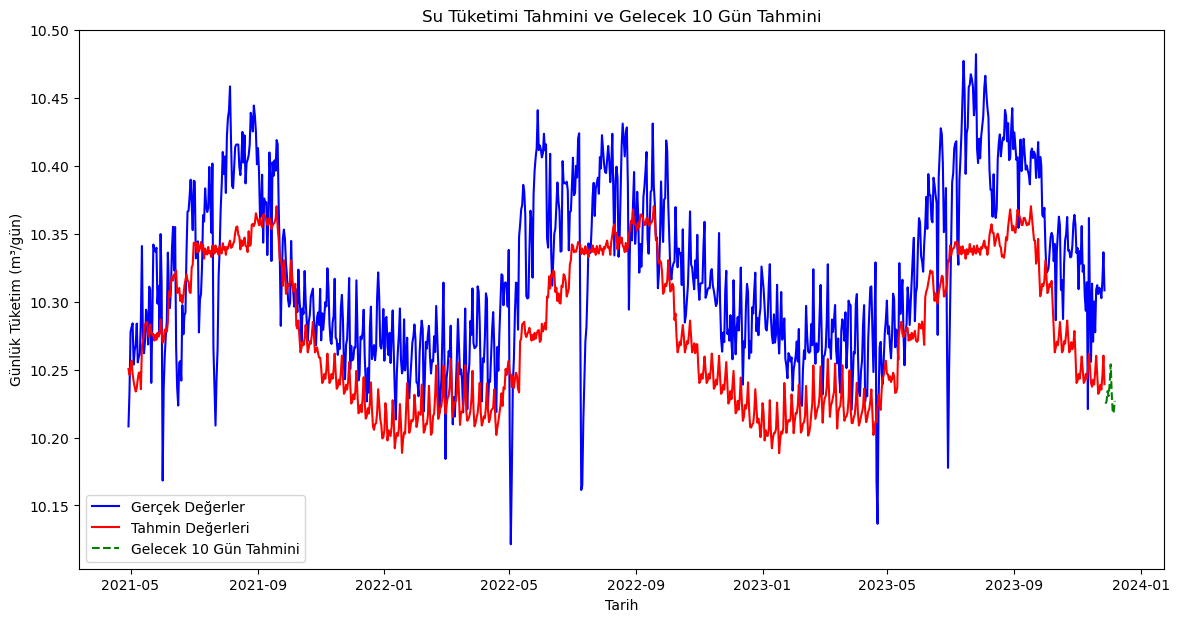

In [8]:
from datetime import datetime, timedelta

# Gelecek 10 günün tarih aralığını belirleme
start_date = df.index[-1] + timedelta(days=1)
end_date = start_date + timedelta(days=9)
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Gelecek 10 gün için özellikler oluşturma
forecast_features = create_features(pd.DataFrame(index=forecast_dates))

# Özellikleri normalize etme
forecast_features_normalized = scaler_X.transform(forecast_features)

# Gelecek 10 günün su tüketimini tahmin etme
forecast_scaled = lgbm_reg.predict(forecast_features_normalized)

# Tahminleri orijinal ölçeklere dönüştürme
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Tahminleri ve tarihleri birleştirme
forecast_results = pd.DataFrame({'Tarih': forecast_dates, 'Tahmin Edilen Su Tüketimi (m³/gün)': forecast})
forecast_results = forecast_results.set_index('Tarih')

# Tahmin edilen su tüketimini görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.plot(forecast_results.index, forecast_results['Tahmin Edilen Su Tüketimi (m³/gün)'], label='Gelecek 10 Gün Tahmini', color='green', linestyle='--')
plt.title('Su Tüketimi Tahmini ve Gelecek 10 Gün Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()


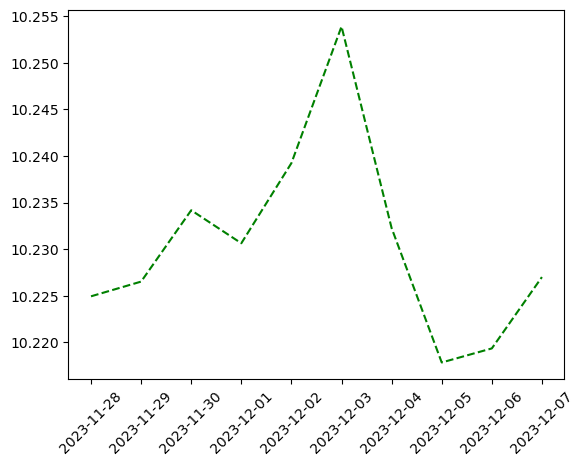

In [9]:
# Gelecek 10 günün tarihlerini daha iyi göstermek için x-eksenini ayarlama
plt.xticks(rotation=45)

# Tahmin edilen su tüketimini görselleştirme
plt.plot(forecast_results.index, forecast_results['Tahmin Edilen Su Tüketimi (m³/gün)'], label='Gelecek 10 Gün Tahmini', color='green', linestyle='--')


In [10]:
from datetime import datetime, timedelta

# Gelecek 365 günün tarih aralığını belirleme
start_date = df.index[-1] + timedelta(days=1)
end_date = start_date + timedelta(days=364)
forecast_dates_1_year = pd.date_range(start=start_date, end=end_date, freq='D')

# Gelecek 1 yıl için özellikler oluşturma
forecast_features_1_year = create_features(pd.DataFrame(index=forecast_dates_1_year))

# Özellikleri normalize etme
forecast_features_normalized_1_year = scaler_X.transform(forecast_features_1_year)

# Gelecek 1 yılın su tüketimini tahmin etme
forecast_scaled_1_year = lgbm_reg.predict(forecast_features_normalized_1_year)

# Tahminleri orijinal ölçeklere dönüştürme
forecast_1_year = scaler_y.inverse_transform(forecast_scaled_1_year.reshape(-1, 1)).flatten()

# Tahminleri ve tarihleri birleştirme
forecast_results_1_year = pd.DataFrame({'Tarih': forecast_dates_1_year, 'Tahmin Edilen Su Tüketimi (m³/gün)': forecast_1_year})
forecast_results_1_year = forecast_results_1_year.set_index('Tarih')

forecast_results_1_year

,Tahmin Edilen Su Tüketimi (m³/gün)
Tarih,
2023-11-28,10.224950
2023-11-29,10.226530
2023-11-30,10.234184
2023-12-01,10.230642
2023-12-02,10.239242
...,...
2024-11-22,10.235320
2024-11-23,10.245702
2024-11-24,10.260358


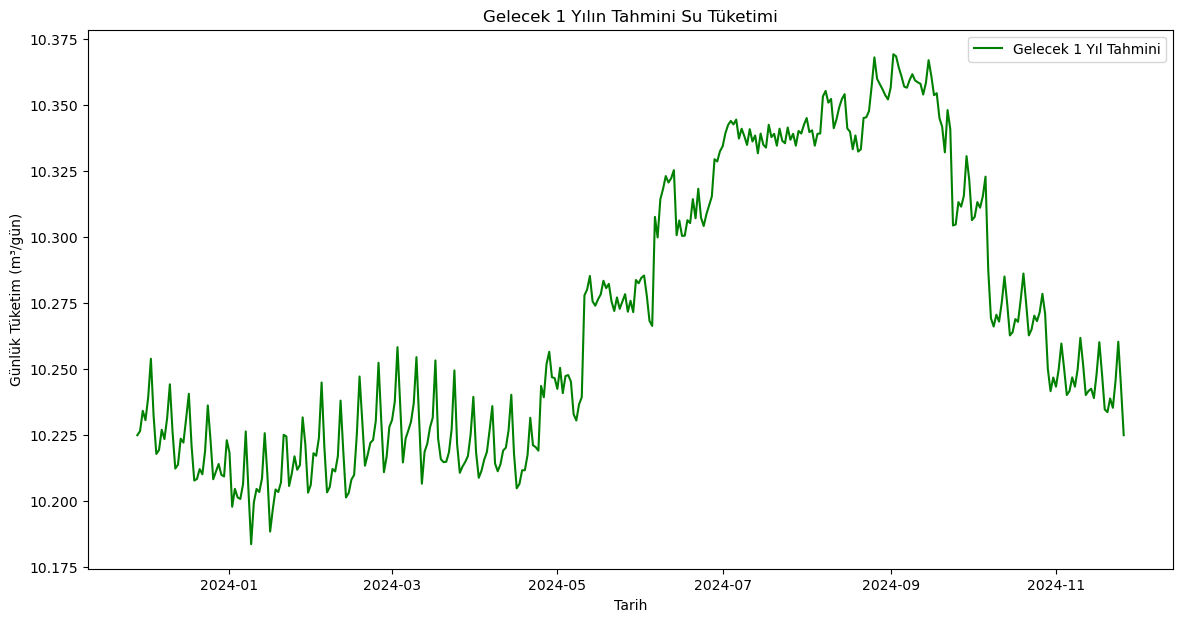

In [11]:
# Tahmin edilen su tüketimini görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(forecast_results_1_year.index, forecast_results_1_year['Tahmin Edilen Su Tüketimi (m³/gün)'], label='Gelecek 1 Yıl Tahmini', color='green')
plt.title('Gelecek 1 Yılın Tahmini Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()
